# Section 8. Increasing Model Efficiency

- Last lecture, we looked at making our bigrams language more more efficient by limiting the number of parameters we used.
- Surprisingly, our nnet model was faster, due to few weight params
- this lecture we can go EVEN FASTER using numpy indexing tricks

### Inefficiency
- In previous model, for every new sentence (batch) we need to create a one-hot-encoded representation of it
    - For a sentence of length N, we generate 2 matrices of size **N x V**
- if V=10,000 then we create 10,000 times more data than we started with!!!

### Matrix multiplication with onehot 
- if we multiply the following vector and matrix (vec.dot(mat)), we get the second row of the matrix. The row that is return is determined by the position of the 1 in the one hot vector. 
![](pictures/nlp_8_matmul.jpg)


In [3]:
import numpy as np
w_mat = np.arange(1,10).reshape(3,3)
oneh_vec = np.array([0,1,0])

oneh_vec.dot(w_mat)

array([4, 5, 6])

### Whats the pattern?
- if my input word  (numerical representation) is k
- then one-hot vector contains 0s and 1 at index k
- then multiplying the one-hot vector by weight matrix is the **the same as selected the kth row of the weight matrix!**

So basically, these two code snipets are equivalent:

      #OLD
      one_hot = get_one_hot(k)
      one_hot.dot(W)
      
      #NEW
      W[k]
      
- The second method is also MUCH faster and takes up LESS memory.
- For a sentence of N length, containing word indexes, we can use that directly instead of create an N x V one-hot matrix. 
- For v=10000 we get a savings of 10000 times!

### Numpy indexing
- I can do W[k] because k is an integer, and thats easy
- by how do we do this for full sentences with multiple word indexes?
- How can we do the equivalent of *one_hot_inputs.dot(W)*?
- Luckily, **numpy actually supports indexing an array with a list of indexes**
- Eg. W[[0,0]] returns a 2xD array with the row at index 0 and the row at index 1
- W[Inputs] returns a NxD matrix where N = sentence length
    - this is the same thing I would have gotten from doing one_hot_inputs.dot(W)
    
if:

        one_hot_inputs.shape == (N,V)
        W.shape == (V,D)

then:
    
        one_hot_inputs.dot(W).shape == (N,D)

In [4]:
#weight matrix for 5 words
w_mat = np.arange(0,35).reshape(5,7)
print('w_mat\n', w_mat)

#numpy indexing
w_mat[[0,0,1],[2,3,6]]

w_mat
 [[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]
 [28 29 30 31 32 33 34]]


array([ 2,  3, 13])

In [5]:
#sentence with 5 setneces, in corpus vocab of 7
sent = np.array([2,4,3,0,2,1,4])
print("Select weight indeces using the 'sent' variable.")
print('No need for one-hot encoding of sent variable!')
print(sent)
print()
w_mat[sent]

Select weight indeces using the 'sent' variable.
No need for one-hot encoding of sent variable!
[2 4 3 0 2 1 4]



array([[14, 15, 16, 17, 18, 19, 20],
       [28, 29, 30, 31, 32, 33, 34],
       [21, 22, 23, 24, 25, 26, 27],
       [ 0,  1,  2,  3,  4,  5,  6],
       [14, 15, 16, 17, 18, 19, 20],
       [ 7,  8,  9, 10, 11, 12, 13],
       [28, 29, 30, 31, 32, 33, 34]])

### Apply this trick everywhere

For predictions:
    
    hidden = np.tanh(W1[inputs])
    predictions = softmax(hidden.dot(W2))
    
### Calculating Cost

- Most of these terms are 0 because anything  x 0 = 0

OLD:
    
    one_hot_targets * log(predictions)

NEW:
    
    log(predictions[np.arange(N), targets])
    
- In the new code, 'targets' is a list of integers (that refer to word in vocab)... we select non-zero entries!

![](pictures/nlp_7_nnetcost.jpg)


### Update W2

- Our original update works as follows:
    
    W2 = W2 - lr * hidden.T.dot(predictions - targets)

- HOWEVER, we can't do this anymore! **Because targets is now a list of integers reflecting wordindex vals... instead of NxV matrix**
- We can no longer subtract these because target is no longer NXV

**Use the double indexing trick:**
- We are mostly subtracting zeros


    W2 = w2 - lr * hidden.T.dot(predictions - onehot_targets)

- we really only need to subtract 1 from where target is, like this:


    doutput = predictions
    doutput[np.arange(N), targets] -=1
    
### Update W1
- Remember, we only need to update the weights corresponding to words in our batch (sentence). 
    - "Recall: we only need to update the part of W1 that corresponds to the input word"
- However, we will have multiple input words, and occasionally the same input word twice!
- **Solution:** pretend we are doing stochastic gradient descent and update one word at a time
    - this is not ideal because we like vectorization more than we like for loops (loops are slow)
    
    
    i=0
    for input_row in inputs:
        W1[input_row] = W1[input_row] - lr * dhidden[i]
        i += 1
- In general, you see that the reason we have to use the loop at all, is because the integer used to index W1 is different from the integer used to index dhidden. 

# Let's write some code!

We are generally going to be copying a lot of code from the past lecture so we will import that below.

# 1. Import old code

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
import os
import sys
from nltk.corpus import brown
import nltk
import operator

#GET SENTENCES FROM BROWN CORPUS
def get_sentences():
    # returns 57340 of the Brown corpus
    # each sentence is represented as a list of individual string tokens
    return brown.sents()
test = get_sentences()

#SENTANCES TO INDEX REPRESENTATION
def get_sentences_with_word2idx(print_v=False):
    #initialize sentences and index
    sentences = get_sentences()
    indexed_sentences = []
    i = 2
    #initialize start/end tags
    #capitalized so wont get confused with actual words in corpus
    word2idx = {'START': 0, 'END': 1}
    
    #loop through all sentances, add unique words to index
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                word2idx[token] = i
                i += 1
            #convert each sentance to index map
            indexed_sentence.append(word2idx[token])
        indexed_sentences.append(indexed_sentence)

    if print_v:
        print("Vocab size:", i)
    return indexed_sentences, word2idx

#SENTANCES TO INDEX REPRESENTATION WITH LIMITED VOCAB
KEEP_WORDS = set([
  'king', 'man', 'queen', 'woman',
  'italy', 'rome', 'france', 'paris',
  'london', 'britain', 'england',
])

def get_sentences_with_word2idx_limit_vocab(n_vocab=2000, keep_words=KEEP_WORDS, print_v=False):
    #initialize sentences and index
    sentences = get_sentences()
    indexed_sentences = []
    i = 2
    #initialize start/end tags
    #capitalized so wont get confused with actual words in corpus
    word2idx = {'START': 0, 'END': 1}
    idx2word = ['START', 'END']
    
    #Set start tokens to inf so they dont get removed when sorting by count
    word_idx_count = {
    0: float('inf'),
    1: float('inf'),
    }
    
    #Count each word 
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                idx2word.append(token)
                word2idx[token] = i
                i += 1
            # keep track of counts for later sorting
            idx = word2idx[token]
            word_idx_count[idx] = word_idx_count.get(idx, 0) + 1

            indexed_sentence.append(idx)
        indexed_sentences.append(indexed_sentence)

    # restrict vocab size
    # set all the words I want to keep to infinity
    # so that they are included when I pick the most
    for word in keep_words:
        word_idx_count[word2idx[word]] = float('inf')
    #tell sorted funciton to use 2nd item to sort
    sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
    word2idx_small = {}
    new_idx = 0
    #create new dictionary from old dict
    idx_new_idx_map = {}
    for idx, count in sorted_word_idx_count[:n_vocab]:
        word = idx2word[idx]
        if print_v:
            print(word, count)
        word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
    # let 'unknown' be the last token
    # replcae all infrequent words are replaced with 'UNKOWN"
    word2idx_small['UNKNOWN'] = new_idx 
    unknown = new_idx
    
    # sanit check to make sure all words wanted to keep are still there
    assert('START' in word2idx_small)
    assert('END' in word2idx_small)
    for word in keep_words:
        assert(word in word2idx_small)

    # map old idx to new idx
    sentences_small = []
    for sentence in indexed_sentences:
        if len(sentence) > 1:
            new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
            sentences_small.append(new_sentence)

    return sentences_small, word2idx_small

def get_bigrams_probs(sentences, V, start_idx, end_idx, smoothing=1):
    # initialize bigram_probs with size vocab * vocab
    # set all values as 1s and multiple mby smoothing (this will ensure minimum values is 1*smoothing value)
    bigram_probs = np.ones((V, V)) * smoothing
    for sentence in sentences:
        for i in range(len(sentence)):
            # begining word... add 1 to col row[0] (previous word) and col[i] (current word)
            # we loop through sentence items because they are in indexed format, so we can use values as indeces
            if i==0:
                bigram_probs[start_idx, sentence[i]] += 1
            else: #middle word
                bigram_probs[sentence[i-1], sentence[i]] += 1
            # if we're at the final word
            # we update the bigram for last -> current, AND current -> END token
            if i == len(sentence) - 1: # END word
                bigram_probs[sentence[i], end_idx] += 1
    # normalize the counts along the rows to get probabilities
    bigram_probs /= bigram_probs.sum(axis=1, keepdims=True)
    return bigram_probs

def softmax(a):
    a = a - a.max()
    exp_a = np.exp(a)
    return exp_a / exp_a.sum(axis=1, keepdims=True)

def smoothed_loss(x, decay=0.99):
    y = np.zeros(len(x))
    last = 0
    for t in range(len(x)):
        z = decay * last + (1-decay) * x[t]
        y[t] = z / (1 - decay ** (t+1))
        last = z
    return y

In [7]:
#import data
sentences, word2idx = get_sentences_with_word2idx_limit_vocab(5000)

#extract dimensions
V = len(word2idx)
start_idx = word2idx['START']
end_idx = word2idx['END']
bigram_probs = get_bigrams_probs(sentences, V, start_idx, end_idx, smoothing=0.1)
print('Vocab length: ', V)
print('Start index: ', start_idx)
print('End index: ', end_idx)
print('Bigram probs:',bigram_probs[0:5].shape)

# what is the loss if we set W = log(bigram_probs)?
W_bigram = np.log(bigram_probs)


Vocab length:  5001
Start index:  0
End index:  1
Bigram probs: (5, 5001)


# 2. Train and run neural net model

In [8]:
# train a shallow neural network model
# D is hidden layer which compresses the data to from size V to D
D = 100 
#initialize random weights
W1 = np.random.randn(V,D) / np.sqrt(V)
W2 = np.random.randn(D,V) / np.sqrt(D)

losses = []
bigram_losses = []
epochs = 1
lr = 1e-2

t0 = datetime.now()
for epoch in range(epochs):
    #randomize sentences
    random.shuffle(sentences)
    
    j = 0 #keep track of iterations
    # remember, we treat each sentence kind of like a minibatch, which is why we get such wild variations in loss
    #only take 10k sentences
    for sentence in sentences[0:10000]:
        sentence = [start_idx] + sentence + [end_idx]
        n = len(sentence)
        
        #USE NUMPY INDEXING TRICK TO EXTRACT INDEX AND TARGETS
        inputs = sentence[:n-1]  
        targets = sentence[1:]
        
        #USE NUMPY INDEXING TO GET PREDICTIONS
        hidden = np.tanh(W1[inputs])
        predictions = softmax(hidden.dot(W2))
        
        # keep track of the loss
        loss = -np.sum(np.log(predictions[np.arange(n - 1), targets])) / (n - 1)
        losses.append(loss)

        # do a gradient descent step
        # do it after loss since the calculation of doutput will overwrite predictions
        # we don't want to make a copy because it would be slow
        doutput = predictions # N x V
        doutput[np.arange(n - 1), targets] -= 1
        W2 = W2 - lr * hidden.T.dot(doutput) # (D x N) (N x V)
        dhidden = doutput.dot(W2.T) * (1 - hidden * hidden) # (N x V) (V x D) * (N x D)
        # # for reference:
        # # original: W1 = W1 - lr * inputs.T.dot(dhidden) # VxN NxD --> VxD

        # test this
        #ONLY UPDATE WEIGHTS IN SENTENCE
        i = 0
        for w in inputs: # don't include end token
            W1[w] = W1[w] - lr * dhidden[i]
        i += 1

        
        # vs this
        # oh_inputs = np.zeros((n - 1, V))
        # oh_inputs[np.arange(n - 1), sentence[:n-1]] = 1
        # W1 = W1 - lr * oh_inputs.T.dot(dhidden)

        # keep track of the bigram loss
        # only do it for the first epoch to avoid redundancy
        if epoch == 0:
            bigram_predictions = softmax(W_bigram[inputs])
            bigram_loss = -np.sum(np.log(bigram_predictions[np.arange(n - 1), targets])) / (n - 1)
            bigram_losses.append(bigram_loss)

        if j % 100 == 0:
            print("epoch:", epoch, "sentence: {}/{}".format(j, len(sentences),"loss:",loss))
        j+=1

print('Elapsed training time:', datetime.now() - t0)

epoch: 0 sentence: 0/57013
epoch: 0 sentence: 100/57013
epoch: 0 sentence: 200/57013
epoch: 0 sentence: 300/57013
epoch: 0 sentence: 400/57013
epoch: 0 sentence: 500/57013
epoch: 0 sentence: 600/57013
epoch: 0 sentence: 700/57013
epoch: 0 sentence: 800/57013
epoch: 0 sentence: 900/57013
epoch: 0 sentence: 1000/57013
epoch: 0 sentence: 1100/57013
epoch: 0 sentence: 1200/57013
epoch: 0 sentence: 1300/57013
epoch: 0 sentence: 1400/57013
epoch: 0 sentence: 1500/57013
epoch: 0 sentence: 1600/57013
epoch: 0 sentence: 1700/57013
epoch: 0 sentence: 1800/57013
epoch: 0 sentence: 1900/57013
epoch: 0 sentence: 2000/57013
epoch: 0 sentence: 2100/57013
epoch: 0 sentence: 2200/57013
epoch: 0 sentence: 2300/57013
epoch: 0 sentence: 2400/57013
epoch: 0 sentence: 2500/57013
epoch: 0 sentence: 2600/57013
epoch: 0 sentence: 2700/57013
epoch: 0 sentence: 2800/57013
epoch: 0 sentence: 2900/57013
epoch: 0 sentence: 3000/57013
epoch: 0 sentence: 3100/57013
epoch: 0 sentence: 3200/57013
epoch: 0 sentence: 330

# 3. Visualize data

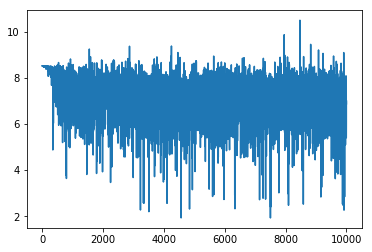

In [9]:
#plot losses to make sure model is working right
plt.plot(losses)
plt.show()

avg_bigram_loss: 4.50508030519


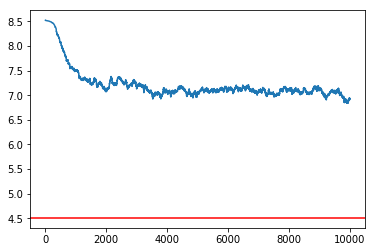

In [11]:
# plot a horizontal line for the bigram loss
avg_bigram_loss = np.mean(bigram_losses)
print("avg_bigram_loss:", avg_bigram_loss)
plt.axhline(y=avg_bigram_loss, color='r', linestyle='-')

plt.plot(smoothed_loss(losses))
plt.show()

# Conclusion

The model is WAY faster (due to the numpy indexing tricks). Also, only updating W1 for relevent words was also super helpful. So instead of updating ALL W1 each iteration, we only update the relevent words in the batch (sentence). 